In [155]:
import cv2
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import random

from torch.utils.data import Dataset, DataLoader

In [9]:
classes = os.listdir('images')
img_dir = 'images'

In [7]:
print(classes)

['butterfly', 'cow', 'elephant', 'sheep', 'squirrel']


In [71]:
def pad(x, border=4):
    return np.pad(x, [(0, 0), (border, border), (border, border)], mode='reflect')

def pad_cv2_format(x, border=4):
    return np.pad(x, [(border, border), (border, border), (0, 0)], mode='reflect')

class RandomPadandCrop(object):
    """Crop randomly the image.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, x):
        x = pad(x, 4)

        h, w = x.shape[1:]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        x = x[:, top: top + new_h, left: left + new_w]

        return x

class RandomFlip(object):
    """Flip randomly the image.
    """
    def __call__(self, x):
        if np.random.rand() < 0.5:
            x = x[:, :, ::-1]

        return x.copy()

class GaussianNoise(object):
    """Add gaussian noise to the image.
    """
    def __call__(self, x):
        c, h, w = x.shape
        x += np.random.randn(c, h, w) * 0.15
        return x

In [10]:
filenames = {}
for cls in classes:
    filenames[cls] = []
    
    path_to_class = os.path.join(img_dir, cls)
    for fname in os.listdir(path_to_class):
        filenames[cls].append(os.path.join(path_to_class, fname))

In [12]:
filenames['butterfly'][:5]

['images\\butterfly\\ea36b00828f6033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg',
 'images\\butterfly\\ea36b00829f0043ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg',
 'images\\butterfly\\ea36b1062df4053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg',
 'images\\butterfly\\ea36b1072df6043ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg',
 'images\\butterfly\\ea36b1072df6073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg']

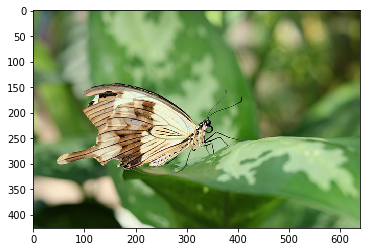

In [42]:
fname = filenames['butterfly'][4]
img = cv2.imread(fname)

def show_img(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
    
show_img(img)
    

# Find minimum sizes

In [20]:
widths  = []
heights = []
for cls in filenames:
    for fname in filenames[cls]:
        try:
            img = cv2.imread(fname)
        except:
            continue
            
        if img is None:
            continue
            
        height, width = img.shape[0], img.shape[1]
        widths.append(width)
        heights.append(height)

In [38]:
n = 128
h_over_n = [height for height in heights if height >= n]
print(len(h_over_n), len(heights))

8145 8196


In [37]:
w_over_n = [width for width in widths if width >= n]
print(len(w_over_n), len(widths))

8196 8196


It would appear most images ar at least 128x128. We will discard the rest so all images can be shown to the user in a decent size.

In [39]:
fnames_128 = {}
for cls in filenames:
    fnames_128[cls] = []
    for fname in filenames[cls]:
        try:
            img = cv2.imread(fname)
        except:
            continue
            
        if img is None:
            continue
            
        height, width = img.shape[0], img.shape[1]
        if height >= 128 and width >= 128:
            fnames_128[cls].append(fname)

In [41]:
print(fnames_128['elephant'][:3])

['images\\elephant\\ea36b0072bfc063ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.jpg', 'images\\elephant\\ea36b0082bf2063ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.jpg', 'images\\elephant\\ea36b0082bf2083ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.jpg']


# Avoid fixed resizing

We will demonstrate how not to resize a rectangular image. If you do it directly to the desired shape you will lose the aspect ratio. We will do it correctly in 2 steps:

    1. Resize so that the smallest side is 128 pixels (while keeping the aspect ratio)
    2. Randomly crop the image

(433, 640, 3)


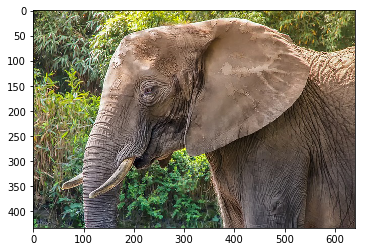

In [52]:
# The original image

fname = fnames_128['elephant'][4]
img = cv2.imread(fname)
print(img.shape)
show_img(img)

(433, 640, 3)


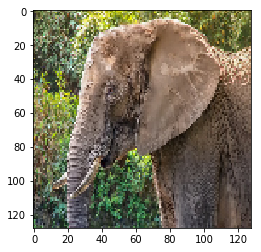

(128, 128, 3)


In [47]:
# The image, resized direcly

img = cv2.imread(fname)
img = cv2.resize(img, (128, 128))
show_img(img)
print(img.shape)

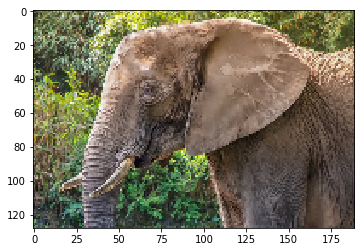

(128, 189, 3)


In [61]:
# The image, resized step 1

img = cv2.imread(fname)
height, width = img.shape[0], img.shape[1]
min_dim = min(height, width)
scaling = min_dim / 128
new_height = int(height / scaling)
new_width = int(width / scaling)
img = cv2.resize(img, (new_width, new_height))
show_img(img)
print(img.shape)

12 0


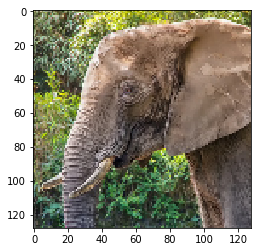

(128, 128, 3)


In [65]:
# The image, resized step 2

start_x = np.random.randint(0, new_width  - 128 + 1)
start_y = np.random.randint(0, new_height - 128 + 1)
print(start_x, start_y)

img_2 = img[start_y:start_y+128, start_x:start_x+128]
show_img(img_2)
print(img_2.shape)

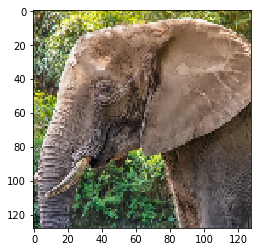

In [68]:
def careful_resize(img):
    height, width = img.shape[0], img.shape[1]
    min_dim = min(height, width)
    scaling = min_dim / 128
    new_height = int(height / scaling)
    new_width = int(width / scaling)
    img_1 = cv2.resize(img, (new_width, new_height))
    
    start_x = np.random.randint(0, new_width  - 128 + 1)
    start_y = np.random.randint(0, new_height - 128 + 1)
    img_2 = img_1[start_y:start_y+128, start_x:start_x+128]
    
    return img_2
    
img_resized = careful_resize(img)
show_img(img_resized)

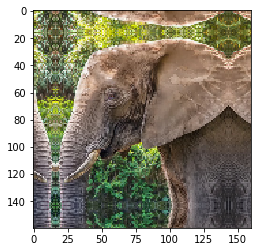

In [73]:
img_padded = pad_cv2_format(img_resized, 16)
show_img(img_padded)

In [115]:
def resize_and_split(img, careful=True, max_aspect_ratio=3, min_new_info=0.2, size=128):
    height, width = img.shape[0], img.shape[1]
    min_dim = min(height, width)
    scaling = min_dim / size
    new_height = int(height / scaling)
    new_width = int(width / scaling)
    img_1 = cv2.resize(img, (new_width, new_height))
    
    max_dim = max(new_height, new_width)
    ratio = max_dim / size
    if ratio > max_aspect_ratio and careful:
        # The aspect ratio of the image is too big; we cannot extract
        # a square portion of this image and have it still represent
        # the class as a whole
        return []
    
    def add_img(result_imgs, start_x, start_y):
        img_tmp = img_1[start_y:start_y+size, start_x:start_x+size]
        result_imgs.append(img_tmp)
    
    result_imgs = []
    if ratio > (1 + min_new_info):
        add_img(result_imgs, 0, 0)
        add_img(result_imgs, new_width - size, new_height - size)
    else:
        start_x = np.random.randint(0, new_width  - size + 1)
        start_y = np.random.randint(0, new_height - size + 1)
        add_img(result_imgs, start_x, start_y)
    
    return result_imgs
    
imgs = resize_and_split(img, size=64)

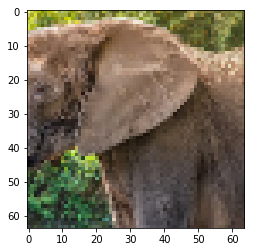

In [99]:
show_img(imgs[1])

In [75]:
def train_val_split(labels, n_labeled_per_class):
    labels = np.array(labels)
    train_labeled_idxs = []
    train_unlabeled_idxs = []
    val_idxs = []

    for i in range(10):
        idxs = np.where(labels == i)[0]
        np.random.shuffle(idxs)
        train_labeled_idxs.extend(idxs[:n_labeled_per_class])
        train_unlabeled_idxs.extend(idxs[n_labeled_per_class:-500])
        val_idxs.extend(idxs[-500:])
    np.random.shuffle(train_labeled_idxs)
    np.random.shuffle(train_unlabeled_idxs)
    np.random.shuffle(val_idxs)

    return train_labeled_idxs, train_unlabeled_idxs, val_idxs

In [79]:
n_labeled = 500
base_dataset = torchvision.datasets.CIFAR10(os.path.join('.', 'tmp'), train=True, 
                        download=True)
train_labeled_idxs, train_unlabeled_idxs, val_idxs = train_val_split(base_dataset.targets,
                        int(n_labeled/10))


Files already downloaded and verified


In [102]:
n_labeled = 500
n_classes = len(classes)
n_labeled_per_class = int(n_labeled / n_classes)

seed = 42
random.seed(seed)

unlabeled_fnames = []
labeled_fnames = {}

for cls in fnames_128:
    random.shuffle(fnames_128[cls])
    
    labeled_fnames[cls] = fnames_128[cls][:n_labeled_per_class]
    unlabeled_fnames.extend(fnames_128[cls][n_labeled_per_class:])

In [104]:
print(len(unlabeled_fnames))
[print(len(labeled_fnames[key])) for key in labeled_fnames]

7644
100
100
100
100
100


[None, None, None, None, None]

In [138]:
import os

class Preprocessor:
    def __init__(self, labeled_fnames, unlabeled_fnames, root='.', size=32,
                    min_new_info=0.4, overwrite=False):
        
        assert (min_new_info >= 0 and min_new_info <= 1)
        assert (os.path.exists(root))
        
        # define label string to integer conversion
        classes = list(labeled_fnames.keys())
        self._int_2_str = dict(enumerate(classes))
        self._str_2_int = dict([(a, b) for b, a in enumerate(classes)])
        
        self.labeled_fnames   = labeled_fnames
        self.unlabeled_fnames = unlabeled_fnames
        
        self.root = root
        self.size = size
        self.min_new_info = min_new_info
        self.overwrite = overwrite 
        
        
        self._preprocess()
        
    def _preprocess(self):
        self.savepath = os.path.join(self.root, "preproc.npz")
        if os.path.exists(self.savepath) and not self.overwrite:
            print('Skipping preprocessing... (found saved file)')
            return
        
        imgs_unl = []
        for fname in self.unlabeled_fnames:
            img = cv2.imread(fname)
            imgs = resize_and_split(img, min_new_info=self.min_new_info,
                                size=self.size)
            imgs_unl.extend(imgs)
            
        imgs_unl = np.array(imgs_unl)
        #tgts_unl = np.full(imgs_unl.shape[0], -1, dtype=int)
        
        imgs_lab = []
        tgts_lab = []
        for cls in self.labeled_fnames:
            int_label = self.str_2_int(cls)
            imgs_cls = []
            for fname in self.labeled_fnames[cls]:
                img = cv2.imread(fname)
                imgs = resize_and_split(img, min_new_info=self.min_new_info,
                                size=self.size)
                imgs_cls.extend(imgs)
            tgts_lab.extend([int_label] * len(imgs_cls))
            imgs_lab.extend(imgs_cls)
           
        imgs_lab = np.array(imgs_lab)
        tgts_lab = np.array(tgts_lab)
        
        np.savez(self.savepath, imgs_lab=imgs_lab, tgts_lab=tgts_lab,
                 imgs_unl=imgs_unl)
        
    def load_all(self):
        npzfile = np.load(self.savepath)
        return (npzfile['imgs_lab'], npzfile['tgts_lab'],
                npzfile['imgs_unl'])
        
    def preprocess(self, img):
        return resize_and_split(img, min_new_info=self.min_new_info,
                                size=self.size)
        
    def int_2_str(self, int_label):
        return self._int_2_str[int_label]
    
    def str_2_int(self, str_label):
        return self._str_2_int[str_label]
        

In [145]:
prep = Preprocessor(labeled_fnames, unlabeled_fnames, overwrite=True, size=64)
imgs_lab, tgts_lab, imgs_unl = prep.load_all()

print(imgs_lab.shape)
print(tgts_lab.shape)
print(imgs_unl.shape)

(733, 64, 64, 3)
(733,)
(11553, 64, 64, 3)


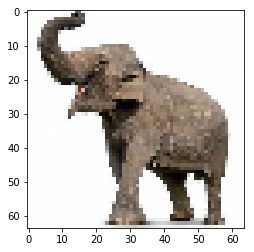

elephant


In [154]:
index = 300
show_img(imgs_lab[index])
print(prep.int_2_str(tgts_lab[index]))

In [157]:
class CustomDataset(Dataset):
    def __init__(self, preprocessor, root='.'):
        pass